In [9]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import scipy.optimize as spo
import scipy.special as sps

In [10]:
#This function takes a 3d array of (size along each dimension = N_side) poisson values of lamda = n_bar and the desired
# power spectrum pk_cl and returns another 3d array of the same dimension with the n(x) following pk_cl(k)

def GonzNuevo(box_p, N_side, L_side, n_bar, pk_cl, k_for_P):
    #Now pixel size of the box
    del_x = L_side/(N_side - 1)

    #Now let's get the density contrast
    box_delx = (box_p - n_bar)/n_bar

    #Now let's take the fourier transform of box_delx to get box_delk
    box_delk = np.fft.fftn(box_delx, norm='ortho')

    # temp_factor = np.power(del_x * np.sqrt(N_side)/np.sqrt(2 * np.pi), 3)
    # box_delk = temp_factor * box_delk

    #Getting the corresponding k values along 1d axis
    k_vals = np.fft.fftfreq(N_side, d= del_x)    

    #Power spectrum of the Poisson field box_delx
    #First I create a 3d array of same shape as box_delk, with values equal
    #to |k| value corresponding to same position in box_delk.
    temb_mesh = np.meshgrid(k_vals, k_vals, k_vals, indexing='ij')
    modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)

    #Now let's iterate through the k_for_P and find the index of modk_grid with k
    #that falls between and find power spectrum pk.
    pk = np.zeros(len(k_for_P)-1)
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        pk[i] = np.average(np.absolute(box_delk[np.where((modk_grid > k1) & (modk_grid < k2))]) ** 2)
    
    # box_vol = L_side**3
    # pk = pk/box_vol

    #----------------------------------------------------------------------------------------------------
    #plotting the pks
    k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.plot(k_for_P_mid, pk)
    ax2.plot(k_for_P_mid, pk_cl)

    ax1.set_xlabel('k')
    ax1.set_ylabel(r'$P_{pois}(k)$')
    ax2.set_xlabel('k')
    ax2.set_ylabel(r'$P_{cl}(k)$')
    #----------------------------------------------------------------------------------------------------
    
    #Make a new delk.
    box_delk_new = np.copy(box_delk)

    #modify the delk using the chosen power spectrum
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        temp_ind = np.where((modk_grid > k1) & (modk_grid < k2))
        box_delk_new[temp_ind] = box_delk[temp_ind] * (np.sqrt(pk_cl[i] + pk[i])) / np.sqrt(pk[i])

    #Now we need to inverse fourier transfor box_delk_new to get box_delx_new
    box_delx_new = np.fft.ifftn(box_delk_new, norm='ortho')
    
    #Now again we have to add the factors
    # del_k = 1/(N_side * del_x)
    # temp_factor = np.power(del_k * np.sqrt(N_side)/np.sqrt(2 * np.pi), 3)
    # box_delx_new = temp_factor * box_delx_new

    #Now to get the new n(x)
    #box_GN = np.asarray(np.round(n_bar * (1 + box_delx_new)), dtype='int64')
    box_GN = n_bar * (1 + box_delx_new)


    #-------------------------------------------------------------------------------------------------------
    #finding the new power spectrum
    pk_new = np.zeros(len(k_for_P)-1)
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        pk_new[i] = np.average(np.absolute(box_delk_new[np.where((modk_grid > k1) & (modk_grid < k2))]) ** 2)
    
    # pk_new = pk_new/box_vol

    #plotting the new psd vs the given one
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.plot(k_for_P_mid, pk_new, label=r'$P_{new}(k)$')
    ax1.plot(k_for_P_mid, pk_cl, label=r'$P_{cl}(k)$')
    ax1.set_xlabel('k')
    ax1.set_ylabel(r'$P(k)$')
    ax1.legend()
    ax2.plot(k_for_P_mid, pk_new-pk_cl, label=r'$P_{new}(k) - P_{cl}(k)$')
    ax2.set_xlabel('k')
    ax2.legend()
    #-------------------------------------------------------------------------------------------------------

    return box_GN
    

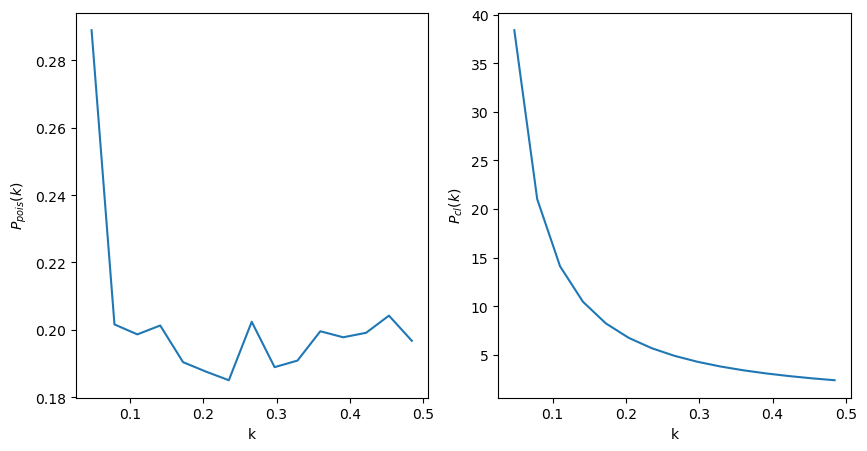

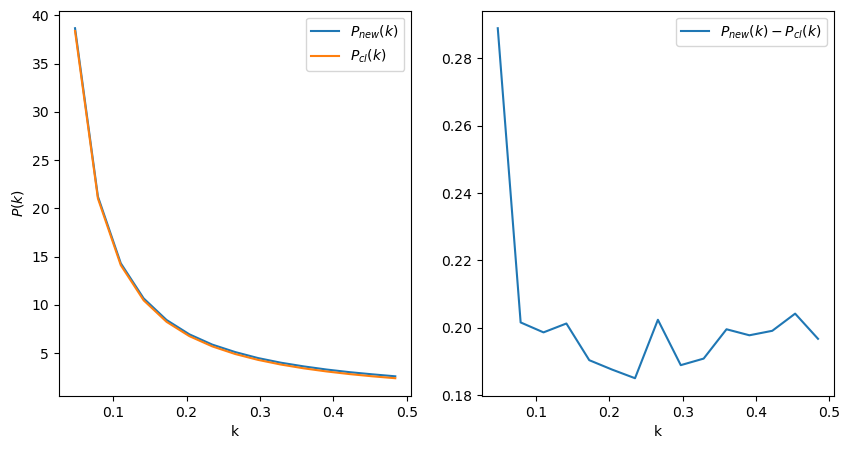

In [11]:
#Let's create a well defined box to hold the number of particles, box_p. 
N_side = 32
#Choose the mean number of particles, n_bar
n_bar = 5
#Choose the total physical length of the box
L_side = 31.0
#Now pixel size of the box
del_x = L_side/(N_side - 1)

#Populate box_p with number of particles drawn from Poisson with mean n_bar.
box_p = np.random.poisson(lam=n_bar, size=(N_side, N_side, N_side))

#Lets make the k's needed for the power spectrum.
k_min = 1/L_side
k_max = 1/(2 * del_x)
assert (N_side % 2 == 0)
k_for_P = np.linspace(k_min, k_max, N_side//2)

#Now we have to make a desired power spectrum pk_cl
k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2
pk_cl = np.power(k_for_P_mid, -1.2)

box_GN = GonzNuevo(box_p, N_side, L_side, n_bar, pk_cl, k_for_P)

/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


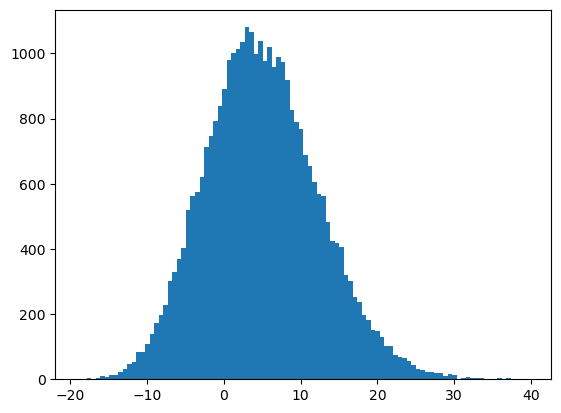

In [16]:
plt.hist(box_GN.flatten(), bins=100);

## Validating the code

### Making different poisson arrays and obtaining its power spectrum

Text(0, 0.5, '$P_{pois}(k)$')

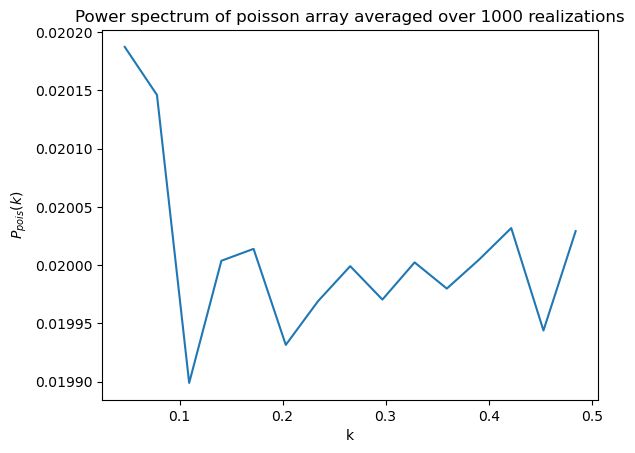

In [60]:
#Let's create a well defined box to hold the number of particles, box_p. 
N_side = 32
#Choose the mean number of particles, n_bar
n_bar = 50
#Choose the total physical length of the box
L_side = 31.0
#Now pixel size of the box
del_x = L_side/(N_side - 1)

#Lets make the k's needed for the power spectrum.
k_min = 1/(N_side  * del_x)
k_max = 1/(2 * del_x)
assert (N_side % 2 == 0)
k_for_P = np.linspace(k_min, k_max, N_side//2)

#Now we have to make a desired power spectrum pk_cl
k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2

def temp_func(box_p, N_side, L_side):
    del_x = L_side/(N_side - 1)

    #Now let's get the density contrast
    box_delx = (box_p - n_bar)/n_bar

    #Now let's take the fourier transform of box_delx to get box_delk
    box_delk = np.fft.fftn(box_delx, norm='ortho')

    # temp_factor = np.power(del_x * np.sqrt(N_side)/np.sqrt(2 * np.pi), 3)
    # box_delk = temp_factor * box_delk

    #Getting the corresponding k values along 1d axis
    k_vals = np.fft.fftfreq(N_side, d= del_x)    

    #Power spectrum of the Poisson field box_delx
    #First I create a 3d array of same shape as box_delk, with values equal
    #to |k| value corresponding to same position in box_delk.
    temb_mesh = np.meshgrid(k_vals, k_vals, k_vals, indexing='ij')
    modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)

    #Temporary start
    # print(np.sum(box_delx)/(np.sqrt(N_side) ** 3))
    # print(box_delk[np.where(modk_grid==0)])
    #Temporary end

    #Now let's iterate through the k_for_P and find the index of modk_grid with k
    #that falls between and find power spectrum pk.
    pk = np.zeros(len(k_for_P)-1)
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        pk[i] = np.average(np.absolute(box_delk[np.where((modk_grid > k1) & (modk_grid < k2))]) ** 2)
        #print("Between ",k1, " and ", k2, "midpoint = ", len(np.where((modk_grid > k1) & (modk_grid < k2))[0])/(((k1 + k2)/2)**2), ", there are ", len(np.where((modk_grid > k1) & (modk_grid < k2))[0]), " k vectors.")

    # box_vol = L_side**3
    # pk = pk/box_vol

    return pk

fig, ax1 = plt.subplots()
ax1.set_title("Power spectrum of poisson array averaged over 1000 realizations")

pk = np.zeros_like(k_for_P_mid)
iter_num = 1000

for i in range(iter_num):
    #Populate box_p with number of particles drawn from Poisson with mean n_bar.
    box_p = np.random.poisson(lam=n_bar, size=(N_side, N_side, N_side))

    pk += temp_func(box_p, N_side, L_side)

pk /= iter_num
ax1.plot(k_for_P_mid, pk)

ax1.set_xlabel('k')
ax1.set_ylabel(r'$P_{pois}(k)$')
    #print(pk[0])

Text(0, 0.5, '$P_{pois}(k)$')

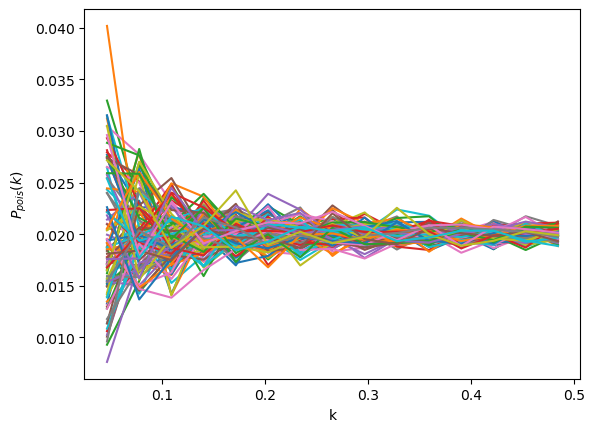

In [61]:
fig, ax1 = plt.subplots()
for i in range(100):
    #Populate box_p with number of particles drawn from Poisson with mean n_bar.
    box_p = np.random.poisson(lam=n_bar, size=(N_side, N_side, N_side))

    pk = temp_func(box_p, N_side, L_side)

    ax1.plot(k_for_P_mid, pk)

ax1.set_xlabel('k')
ax1.set_ylabel(r'$P_{pois}(k)$')

## Let me find the correlation function of box_delx

In [372]:
#Let's create a well defined box to hold the number of particles, box_p. 
N_side = 32
#Choose the mean number of particles, n_bar
n_bar = 50
#Choose the total physical length of the box
L_side = 31.0
#Now pixel size of the box
del_x = L_side/(N_side - 1)

#Populate box_p with number of particles drawn from Poisson with mean n_bar.
box_p = np.random.poisson(lam=n_bar, size=(N_side, N_side, N_side))

#Lets make the k's needed for the power spectrum.
k_min = 1/L_side
k_max = 1/(2 * del_x)
assert (N_side % 2 == 0)
k_for_P = np.linspace(k_min, k_max, N_side//2)

#Now we have to make a desired power spectrum pk_cl
k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2
pk_cl = np.power(k_for_P_mid, -1.2)

box_GN = GonzNuevo(box_p, N_side, L_side, n_bar, pk_cl, k_for_P);
plt.close('all')

/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


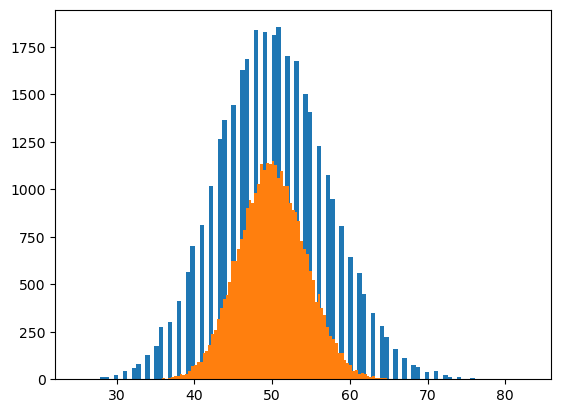

In [385]:
plt.hist(box_p.flatten(), bins=100);
plt.hist(box_GN.flatten(), bins=100);

In [386]:
#Let me make another box, which we will fill with Poisson drawn numbers.
#This will be used as the random catalog in our analysis.
N_side_r = N_side
n_bar_r = n_bar

box_r = np.random.poisson(lam=n_bar_r, size=(N_side_r, N_side_r, N_side_r))

In [387]:
#Here I am finding the correlation function of the box. I use the Corrfunc's DD function. I give all the pixel positions
#as the cartesian positin of points. The n(x) at the site is given as weights.
bins = np.arange(1, N_side)
x1, y1, z1 = np.asarray(np.meshgrid(np.arange(N_side), np.arange(N_side), np.arange(N_side)), dtype='float')
x1 = x1.flatten()
y1 = y1.flatten()
z1 = z1.flatten()
weights1 = np.asarray(box_p.flatten(), dtype='float')

result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, weight_type='pair_product', periodic=False, output_ravg=True)

#Lets find similarly the DR and RR.
weights2 = np.asarray(box_r.flatten(), dtype='float')
x_r, y_r, z_r = np.asarray(np.meshgrid(np.arange(N_side_r), np.arange(N_side_r), np.arange(N_side_r)), dtype='float')
x_r = x_r.flatten()
y_r = y_r.flatten()
z_r = z_r.flatten()
result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x_r, Y1 = y_r, Z1 = z_r, weights1 = weights2, weight_type='pair_product', periodic=False, output_ravg=True)

result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, X2 = x_r, Y2 = y_r, Z2 = z_r, weights2 = weights2, \
               weight_type='pair_product', periodic=False, output_ravg=True)

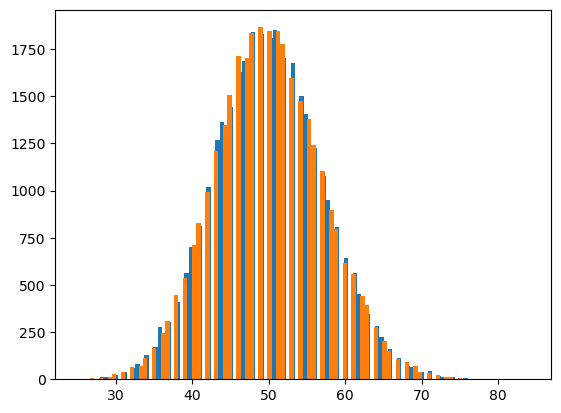

In [388]:
plt.hist(weights1, bins=100);
plt.hist(weights2, bins=100);

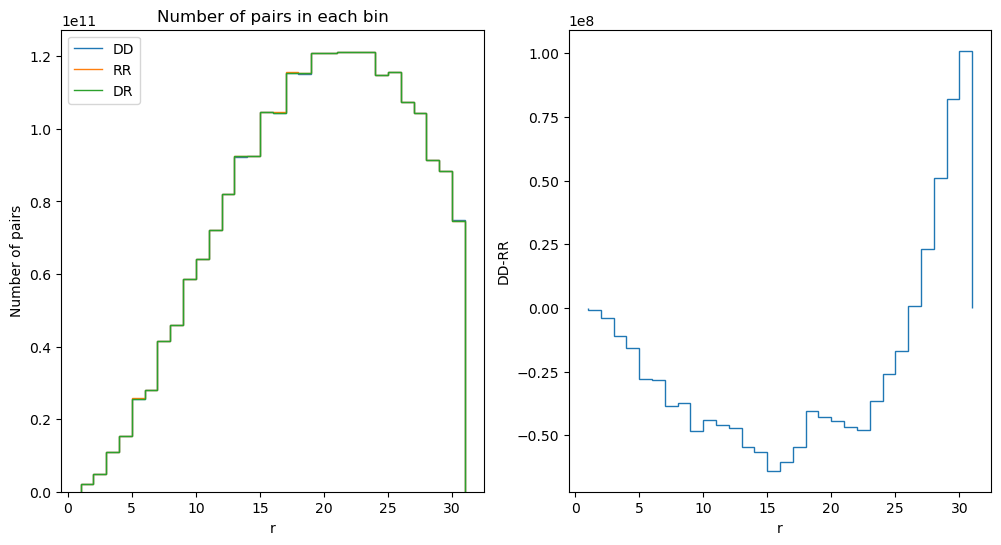

In [389]:
x_bins = bins * del_x

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.stairs(result_DD['npairs']*result_DD['weightavg'], edges=x_bins, label='DD')
ax1.set_title('Number of pairs in each bin')
ax1.set_ylabel('Number of pairs')
ax1.set_xlabel('r')

ax1.stairs(result_RR['npairs']*result_RR['weightavg'], edges=x_bins, label='RR')
ax1.stairs(result_DR['npairs']*result_DR['weightavg'], edges=x_bins, label='DR')

ax2.stairs(result_DD['npairs']*result_DD['weightavg'] - result_RR['npairs']*result_RR['weightavg'], edges=x_bins)
ax2.set_ylabel("DD-RR")
ax2.set_xlabel("r")
ax1.legend()

Text(0.5, 1.0, '2pcf of a poisson lattice')

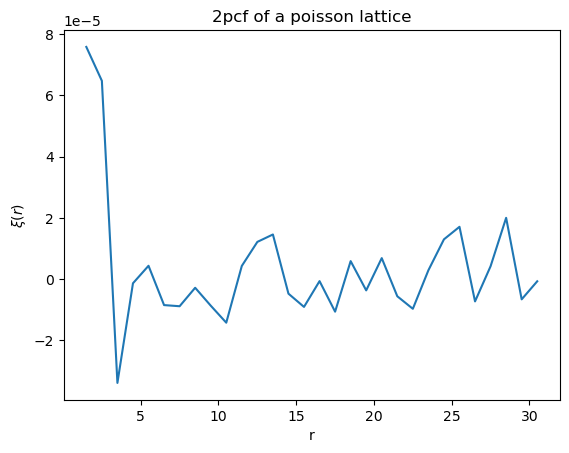

In [390]:
#Now with DD, RR and DR that we obtained, we will find the xi(r), two point correlation function.
#We need normalisation also, which is the total number of pairs.
DD_count = (result_DD['npairs']*result_DD['weightavg'])/2
DR_count = result_DR['npairs']*result_DR['weightavg']
RR_count = (result_RR['npairs']*result_RR['weightavg'])/2
DD_total = (np.sum(weights1) * (np.sum(weights1) - 1))/2
RR_total = (np.sum(weights2) * (np.sum(weights2) - 1))/2
DR_total = (np.sum(weights1) * np.sum(weights2))

Xi = (DD_count/DD_total - 2 * DR_count/DR_total + RR_count/RR_total)/(RR_count/RR_total)

r_mid = (bins[:-1] + bins[1:])/2
fig, ax = plt.subplots()
ax.plot(r_mid, Xi)
ax.set_xlabel('r')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title('2pcf of a poisson lattice')
#Since we are finding the correlation function of a Poisson lattice, we expect zero correlation function.

In [391]:
#Now we can find the correlation function of box_GN. Using the same way.
bins = np.arange(1, N_side)
x1, y1, z1 = np.asarray(np.meshgrid(np.arange(N_side), np.arange(N_side), np.arange(N_side)), dtype='float')
x1 = x1.flatten()
y1 = y1.flatten()
z1 = z1.flatten()
weights1 = np.asarray(box_GN.flatten(), dtype='float')

result_DD_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, weight_type='pair_product', periodic=False, output_ravg=True)

#Lets find similarly the DR and RR.
weights2 = np.asarray(box_r.flatten(), dtype='float')
x_r, y_r, z_r = np.asarray(np.meshgrid(np.arange(N_side_r), np.arange(N_side_r), np.arange(N_side_r)), dtype='float')
x_r = x_r.flatten()
y_r = y_r.flatten()
z_r = z_r.flatten()
result_RR_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x_r, Y1 = y_r, Z1 = z_r, weights1 = weights2, weight_type='pair_product', periodic=False, output_ravg=True)

result_DR_GN = DD(autocorr=0, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, X2 = x_r, Y2 = y_r, Z2 = z_r, weights2 = weights2, \
               weight_type='pair_product', periodic=False, output_ravg=True)

/tmp/ipykernel_805372/678530758.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  weights1 = np.asarray(box_GN.flatten(), dtype='float')


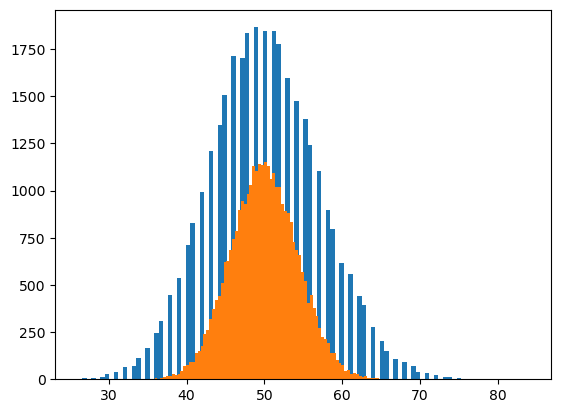

In [393]:
plt.hist(weights2, bins=100);
plt.hist(weights1, bins=100);

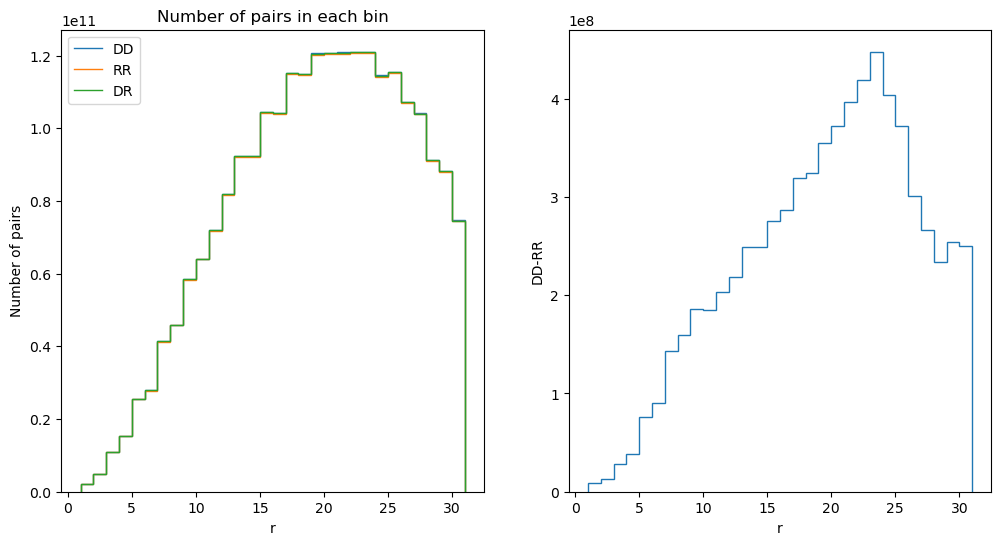

In [351]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.stairs(result_DD_GN['npairs']*result_DD_GN['weightavg'], edges=bins, label='DD')
ax1.set_title('Number of pairs in each bin')
ax1.set_ylabel('Number of pairs')
ax1.set_xlabel('r')

ax1.stairs(result_RR_GN['npairs']*result_RR_GN['weightavg'], edges=bins, label='RR')
ax1.stairs(result_DR['npairs']*result_DR['weightavg'], edges=bins, label='DR')

ax2.stairs(result_DD_GN['npairs']*result_DD_GN['weightavg'] - result_RR_GN['npairs']*result_RR_GN['weightavg'], edges=bins)
ax2.set_ylabel("DD-RR")
ax2.set_xlabel("r")
ax1.legend()

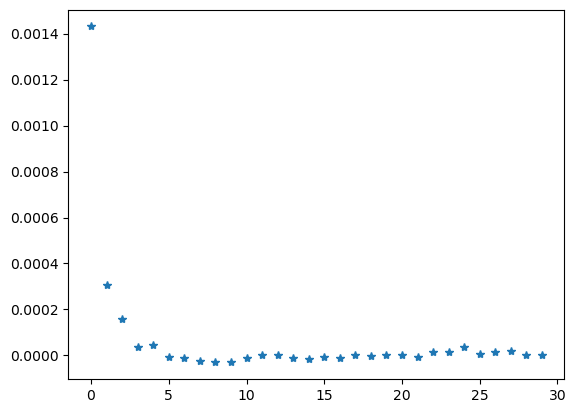

In [394]:
#Now with DD, RR and DR that we obtained, we will find the xi(r), two point correlation function.
#We need normalisation also, which is the total number of pairs.
DD_count_GN = (result_DD_GN['npairs']*result_DD_GN['weightavg'])/2
DR_count_GN = result_DR_GN['npairs']*result_DR_GN['weightavg']
RR_count_GN = (result_RR_GN['npairs']*result_RR_GN['weightavg'])/2
DD_total_GN = (np.sum(weights1) * (np.sum(weights1) - 1))/2
RR_total_GN = (np.sum(weights2) * (np.sum(weights2) - 1))/2
DR_total_GN = (np.sum(weights1) * np.sum(weights2))

Xi_GN = (DD_count_GN/DD_total_GN - 2 * DR_count_GN/DR_total_GN + RR_count_GN/RR_total_GN)/(RR_count_GN/RR_total_GN)

plt.plot(Xi_GN, '*')

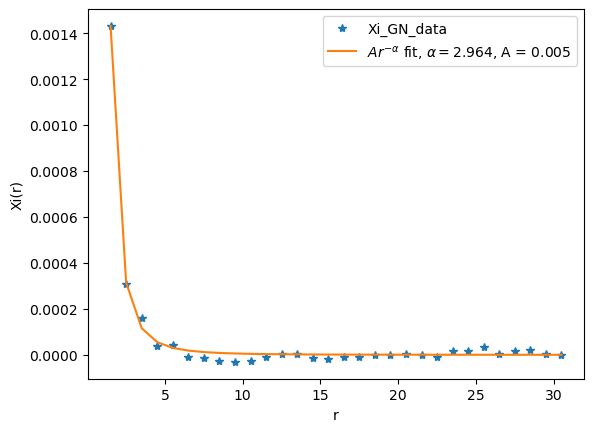

In [395]:
#Fitting the Xi_GN with a power law function to check what degree of correlation we get
def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

r_mid = (bins[:-1] + bins[1:])/2

popt, pcov = spo.curve_fit(pow_func, r_mid, Xi_GN)

fig, ax = plt.subplots()

ax.plot(r_mid, Xi_GN, '*', label = "Xi_GN_data")
ax.plot(r_mid, pow_func(r_mid, popt[0], popt[1]), label=r'$Ar^{{-\alpha}}$ fit, $\alpha = ${}, A = {}'.format(np.round(popt[1],3), np.round(popt[0],3)))
ax.set_xlabel('r')
ax.set_ylabel('Xi(r)')
ax.legend()

## Checking the realtionship between $k^{-\delta}$ and $r^{-\alpha}$

In [3]:
#Let's create a well defined box to hold the number of particles, box_p. 
N_side = 32
#Choose the mean number of particles, n_bar
n_bar = 50
#Choose the total physical length of the box
L_side = 31.0
#Now pixel size of the box
del_x = L_side/(N_side - 1)

#Populate box_p with number of particles drawn from Poisson with mean n_bar.
box_p = np.random.poisson(lam=n_bar, size=(N_side, N_side, N_side))

#Lets make the k's needed for the power spectrum.
k_min = 1/(N_side * del_x)
k_max = 1/(2 * del_x)
assert (N_side % 2 == 0)
k_for_P = np.linspace(k_min, k_max, N_side//2)

#Now we have to make a desired power spectrum pk_cl
delta_of_k = 1.2
const_of_k = 1
k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2
pk_cl = np.power(const_of_k * k_for_P_mid, -delta_of_k)

box_GN = GonzNuevo(box_p, N_side, L_side, n_bar, pk_cl, k_for_P);
plt.close('all')


#Let me make another box, which we will fill with Poisson drawn numbers.
#This will be used as the random catalog in our analysis.
N_side_r = N_side
n_bar_r = n_bar

box_r = np.random.poisson(lam=n_bar_r, size=(N_side_r, N_side_r, N_side_r))

#Now we can find the correlation function of box_GN. Using the same way.
bins = np.arange(1, 20)
x1, y1, z1 = np.asarray(np.meshgrid(np.arange(N_side), np.arange(N_side), np.arange(N_side)), dtype='float')
x1 = x1.flatten()
y1 = y1.flatten()
z1 = z1.flatten()
weights1 = np.asarray(box_GN.flatten(), dtype='float')

result_DD_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, weight_type='pair_product', periodic=False, output_ravg=True)

#Lets find similarly the DR and RR.
weights2 = np.asarray(box_r.flatten(), dtype='float')
x_r, y_r, z_r = np.asarray(np.meshgrid(np.arange(N_side_r), np.arange(N_side_r), np.arange(N_side_r)), dtype='float')
x_r = x_r.flatten()
y_r = y_r.flatten()
z_r = z_r.flatten()
result_RR_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x_r, Y1 = y_r, Z1 = z_r, weights1 = weights2, weight_type='pair_product', periodic=False, output_ravg=True)

result_DR_GN = DD(autocorr=0, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, X2 = x_r, Y2 = y_r, Z2 = z_r, weights2 = weights2, \
               weight_type='pair_product', periodic=False, output_ravg=True)

#Now with DD, RR and DR that we obtained, we will find the xi(r), two point correlation function.
#We need normalisation also, which is the total number of pairs.
DD_count_GN = (result_DD_GN['npairs']*result_DD_GN['weightavg'])/2
DR_count_GN = result_DR_GN['npairs']*result_DR_GN['weightavg']
RR_count_GN = (result_RR_GN['npairs']*result_RR_GN['weightavg'])/2
DD_total_GN = (np.sum(weights1) * (np.sum(weights1) - 1))/2
RR_total_GN = (np.sum(weights2) * (np.sum(weights2) - 1))/2
DR_total_GN = (np.sum(weights1) * np.sum(weights2))

Xi_GN = (DD_count_GN/DD_total_GN - 2 * DR_count_GN/DR_total_GN + RR_count_GN/RR_total_GN)/(RR_count_GN/RR_total_GN)

/tmp/ipykernel_3916/4247607477.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  weights1 = np.asarray(box_GN.flatten(), dtype='float')
[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


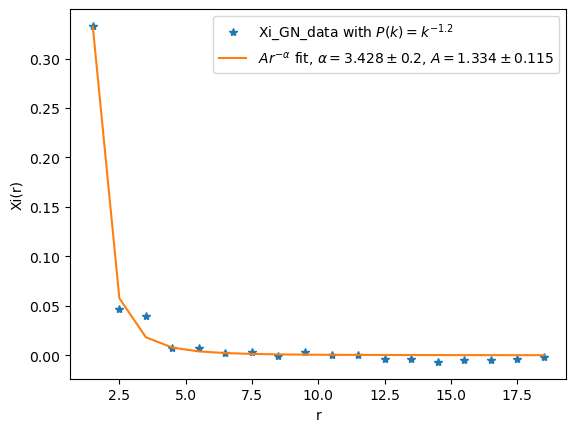

In [4]:
#Fitting the Xi_GN with a power law function to check what degree of correlation we get
def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

r_bins = bins * del_x
r_mid = (r_bins[:-1] + r_bins[1:])/2

popt, pcov = spo.curve_fit(pow_func, r_mid, Xi_GN)

fig, ax = plt.subplots()

ax.plot(r_mid, Xi_GN, '*', label = r"Xi_GN_data with $P(k) = k^{{-{}}}$".format(delta_of_k))
ax.plot(r_mid, pow_func(r_mid, popt[0], popt[1]), label=r'$Ar^{{-\alpha}}$ fit, $\alpha = {}\pm{}$, $A = {}\pm{}$'.format(np.round(popt[1],3),np.round(np.sqrt(pcov[1,1]), 2), \
                                                                                                                        np.round(popt[0],3), np.round(np.sqrt(pcov[0,0]),3)))
ax.set_xlabel('r')
ax.set_ylabel('Xi(r)')

#Expected correlation function
alpha_expect = 3 - delta_of_k
A_expect = (sps.gamma(alpha_expect/2) * np.power(2 * np.pi, 3 - alpha_expect))/ (const_of_k * np.power(2, 1 - alpha_expect/2) * sps.gamma((3 - alpha_expect)/2))
#ax.plot(r_mid, pow_func(r_mid, A_expect, alpha_expect), label=r"Expected $\xi(r)$: $\alpha = {}, A = {}$".format(np.round(alpha_expect,3), np.round(A_expect,3)))

ax.legend()

## relation between delta and alpha in a plot

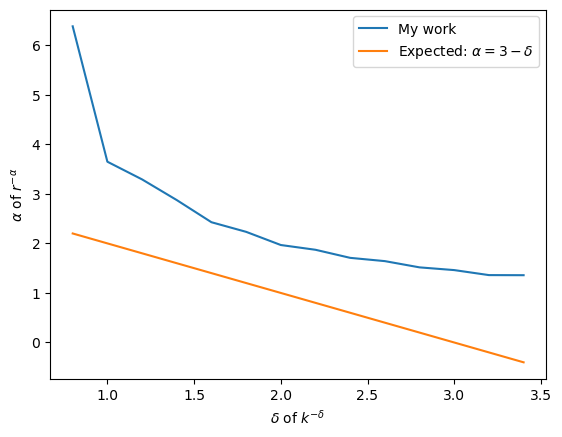

In [8]:
temp_delta_array = np.array([0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4])
temp_alpha_array = np.array([6.38, 3.648, 3.291, 2.874, 2.427, 2.233, 1.967, 1.871, 1.708, 1.642, 1.516, 1.461, 1.36, 1.358])

plt.plot(temp_delta_array, temp_alpha_array, label="My work")
plt.xlabel(r'$\delta$ of $k^{-\delta}$')
plt.ylabel(r'$\alpha$ of $r^{-\alpha}$')
plt.plot(temp_delta_array, 3 - temp_delta_array, label=r"Expected: $\alpha = 3 - \delta$")
plt.legend()